In [1]:
%run Utils.ipynb
%run CollaborativeFiltering.ipynb

In [2]:
class Recommender():
    
    def __init__(self, dataFile):
        
        self.Y, self.R = DATA.loadData(file=dataFile)
        self.predictions = None
        self.X = None
        self.Theta = None
        
    def fit(self, batchSize = None , numFeature = 10, maxItr = 1000, lam = 10, fileName = None):
        
        YNorm, self.YMean = Normalize.normalize(self.Y, self.R)
        numMovie, numUser = self.Y.shape

        X = rand.rand(numMovie, numFeature)
        Theta = rand.rand(numUser, numFeature)
        initialParam = np.concatenate((X, Theta)).ravel()

        anim = AnimateScores(maxItr)
        costs = []
        counts= []
        
        options = {'maxiter': maxItr, 'disp': True}
        args = (YNorm, self.R, numUser, numMovie, numFeature, lam, batchSize, anim ,costs, counts)
        if batchSize is None:
            print('...Gradient descent...')
            fileName = fileName + '-GD'
            optimum = minimize(CollaborativeFilter.cost, initialParam, args=args, jac=CollaborativeFilter.gradient, method='CG',
                           options=options)
        else:
            print('...Stochastic gradient descent...')
            fileName = fileName + '-SGD'
            optimum = minimize(CollaborativeFilter.cost, initialParam, args=args, jac=CollaborativeFilter.stochasticGradient, method='CG',
                           options=options)

        # Saving the graphs
        if fileName is not None:
            print('Saving images...')
            anim.plot_static_graph(costs, file = fileName)
            anim.save(fileName)
        
        print('Optimal cost is {} with status {} after {} iterations '.format(optimum.fun, optimum.success, optimum.nit))
        
        theta = optimum.x
        self.X = np.reshape(theta[0:numMovie * numFeature], (numMovie, numFeature))
        self.Theta = np.reshape(theta[numMovie * numFeature:], (numUser, numFeature))
        
    def predict(self):
        
        if self.X is None or self.Theta is None:
            raise RuntimeError('Model is not fitted yet, run fit method first...')
        
        self.predictions = self.X.dot(self.Theta.T)
        return self.predictions
        
    def giveRatings(self, movieFileName):
        
        self.movieList = DATA.readTXT(movieFileName)
        myMovieRating = np.zeros((len(self.movieList), 1))

        myMovieRating[0] = 4
        myMovieRating[97] = 2
        myMovieRating[6] = 3
        myMovieRating[11] = 5
        myMovieRating[53] = 4
        myMovieRating[63] = 5
        myMovieRating[65] = 3
        myMovieRating[68] = 5
        myMovieRating[182] = 4
        myMovieRating[225] = 5
        myMovieRating[354] = 5

        for i in range(0, len(myMovieRating)):
            if myMovieRating[i] != 0:
                print('Rated {} for movie {}'.format(int(myMovieRating[i]), self.movieList[i]))
                
        self.Y = np.concatenate((myMovieRating, self.Y), axis=1)
        self.R = np.concatenate(((myMovieRating > 0).astype(int), self.R), axis=1)
        
    def recommend(self):
        
        if self.predictions is None:
            raise RuntimeError('predict method has not been executed, run predict before recommending...')
        
        myRecommendations = np.reshape(self.predictions[:, 1], (len(self.predictions[:, 1]), 1)) + self.YMean

        sortedIndex = np.argsort(myRecommendations, axis=0)[::-1]
        
        print('\nTop Recommendations:- ')
        for i in range(0, 10):
            j = sortedIndex[i].item()
            print(' Rating {} for movie {}'.format(myRecommendations[j], self.movieList[j]))

    def saveTrainedData(self, file):
        trainedData = {'X': self.X, 'Theta': self.Theta}
        spi.savemat(file, trainedData)
        

In [3]:
def RecommenderModel(dataFile, movieFileName, maxItr = 1000,  batch_size=None, fileName=None):
    
    model = Recommender(dataFile)
    
    model.giveRatings(movieFileName)
    
    print('\n----Training------')
    model.fit(maxItr = maxItr, batchSize=batch_size, fileName = fileName)
    
    model.predict()
    
    print('\n----Recommendations------')
    model.recommend()

Rated 4 for movie Toy Story (1995)
Rated 3 for movie Twelve Monkeys (1995)
Rated 5 for movie Usual Suspects, The (1995)
Rated 4 for movie Outbreak (1995)
Rated 5 for movie Shawshank Redemption, The (1994)
Rated 3 for movie While You Were Sleeping (1995)
Rated 5 for movie Forrest Gump (1994)
Rated 2 for movie Silence of the Lambs, The (1991)
Rated 4 for movie Alien (1979)
Rated 5 for movie Die Hard 2 (1990)
Rated 5 for movie Sphere (1998)

----Training------
...Gradient descent...
Optimization terminated successfully.
         Current function value: 38951.847560
         Iterations: 478
         Function evaluations: 756
         Gradient evaluations: 755
Saving images...


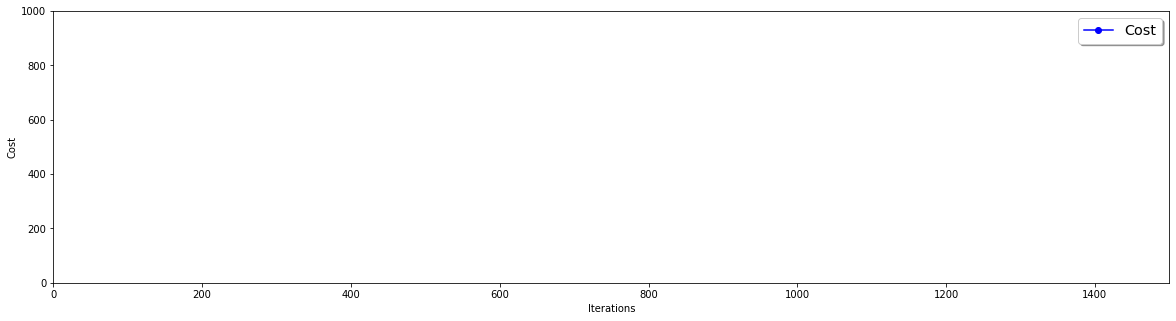

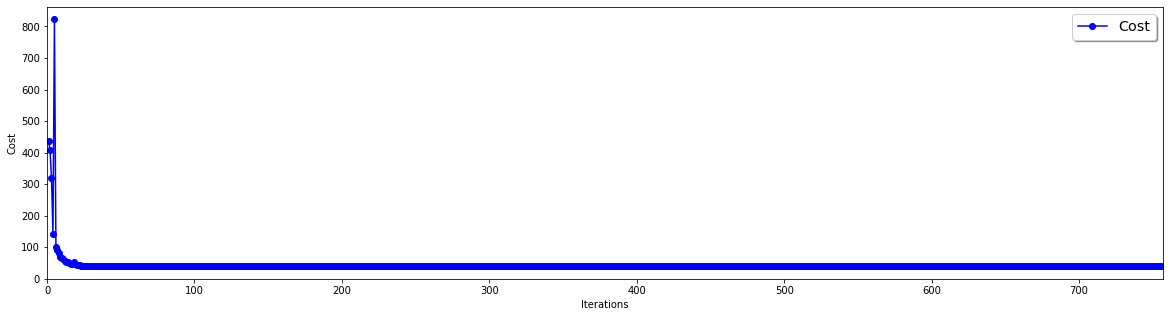

.... Saving aimation Results/Scores-GD.gif


AttributeError: 'AnimateScores' object has no attribute 'anim'

In [4]:
RecommenderModel('data.mat', 'movie_ids.txt', maxItr = 1000,  batch_size=None, fileName='Scores')